<a href="https://colab.research.google.com/github/patil-suraj/SwinIR-JAX/blob/main/swin_ir_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq git+https://github.com/patil-suraj/SwinIR-JAX.git

In [6]:
%%capture
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/00003.png
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/0014.jpg
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/0030.jpg
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/ADE_val_00000114.jpg
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/Lincoln.png
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/OST_009.png
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/building.png
!wget https://github.com/JingyunLiang/SwinIR/raw/main/testsets/RealSRSet%2B5images/butterfly.png

In [2]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
import jax

In [3]:
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 8 JAX devices of type Cloud TPU.


In [4]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard

from PIL import Image

from swin_ir_jax import FlaxSwinIR, prepare_inputs, numpy_to_pil

In [10]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
model, params = FlaxSwinIR.from_pretrained("valhalla/SwinIR-real-sr-L-x4-GAN", _do_init=False)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112M [00:00<?, ?B/s]

In [7]:
params = replicate(params)

In [14]:
paths = [
  "./00003.png",
  "./0014.jpg",
  "./0030.jpg",
  "./ADE_val_00000114.jpg",
  "./Lincoln.png",
  "./OST_009.png",
  "./building.png",
  "./butterfly.png",
]
images = [Image.open(path).convert("RGB") for path in paths]
# resize to same size so we can stack them
height, width = 128, 128
images = [image.resize((height, width)) for image in images]

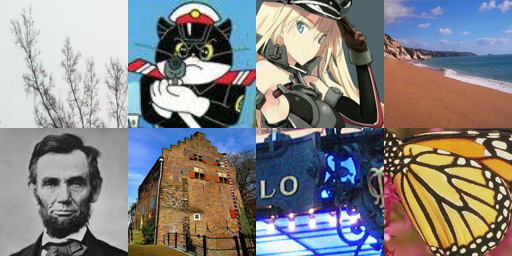

In [15]:
image_grid(images, 2, 4)

In [17]:
inputs = prepare_inputs(images)
inputs = shard(inputs)
inputs.shape

(8, 1, 136, 136, 3)

In [26]:
def upscale(images, params):
  outputs = model(images, params=params)
  return outputs

p_upscale = jax.pmap(upscale)

In [35]:
%%time
sr_images = p_upscale(inputs, params)
sr_images = sr_images.reshape((sr_images.shape[0] * sr_images.shape[1], ) + sr_images.shape[-3:])

CPU times: user 221 ms, sys: 284 ms, total: 504 ms
Wall time: 921 ms


In [36]:
sr_images.shape

(8, 544, 544, 3)

In [37]:
scale = model.config.upscale
sr_images = sr_images[..., :height * scale, :width * scale]
sr_images.shape

(8, 544, 512, 3)

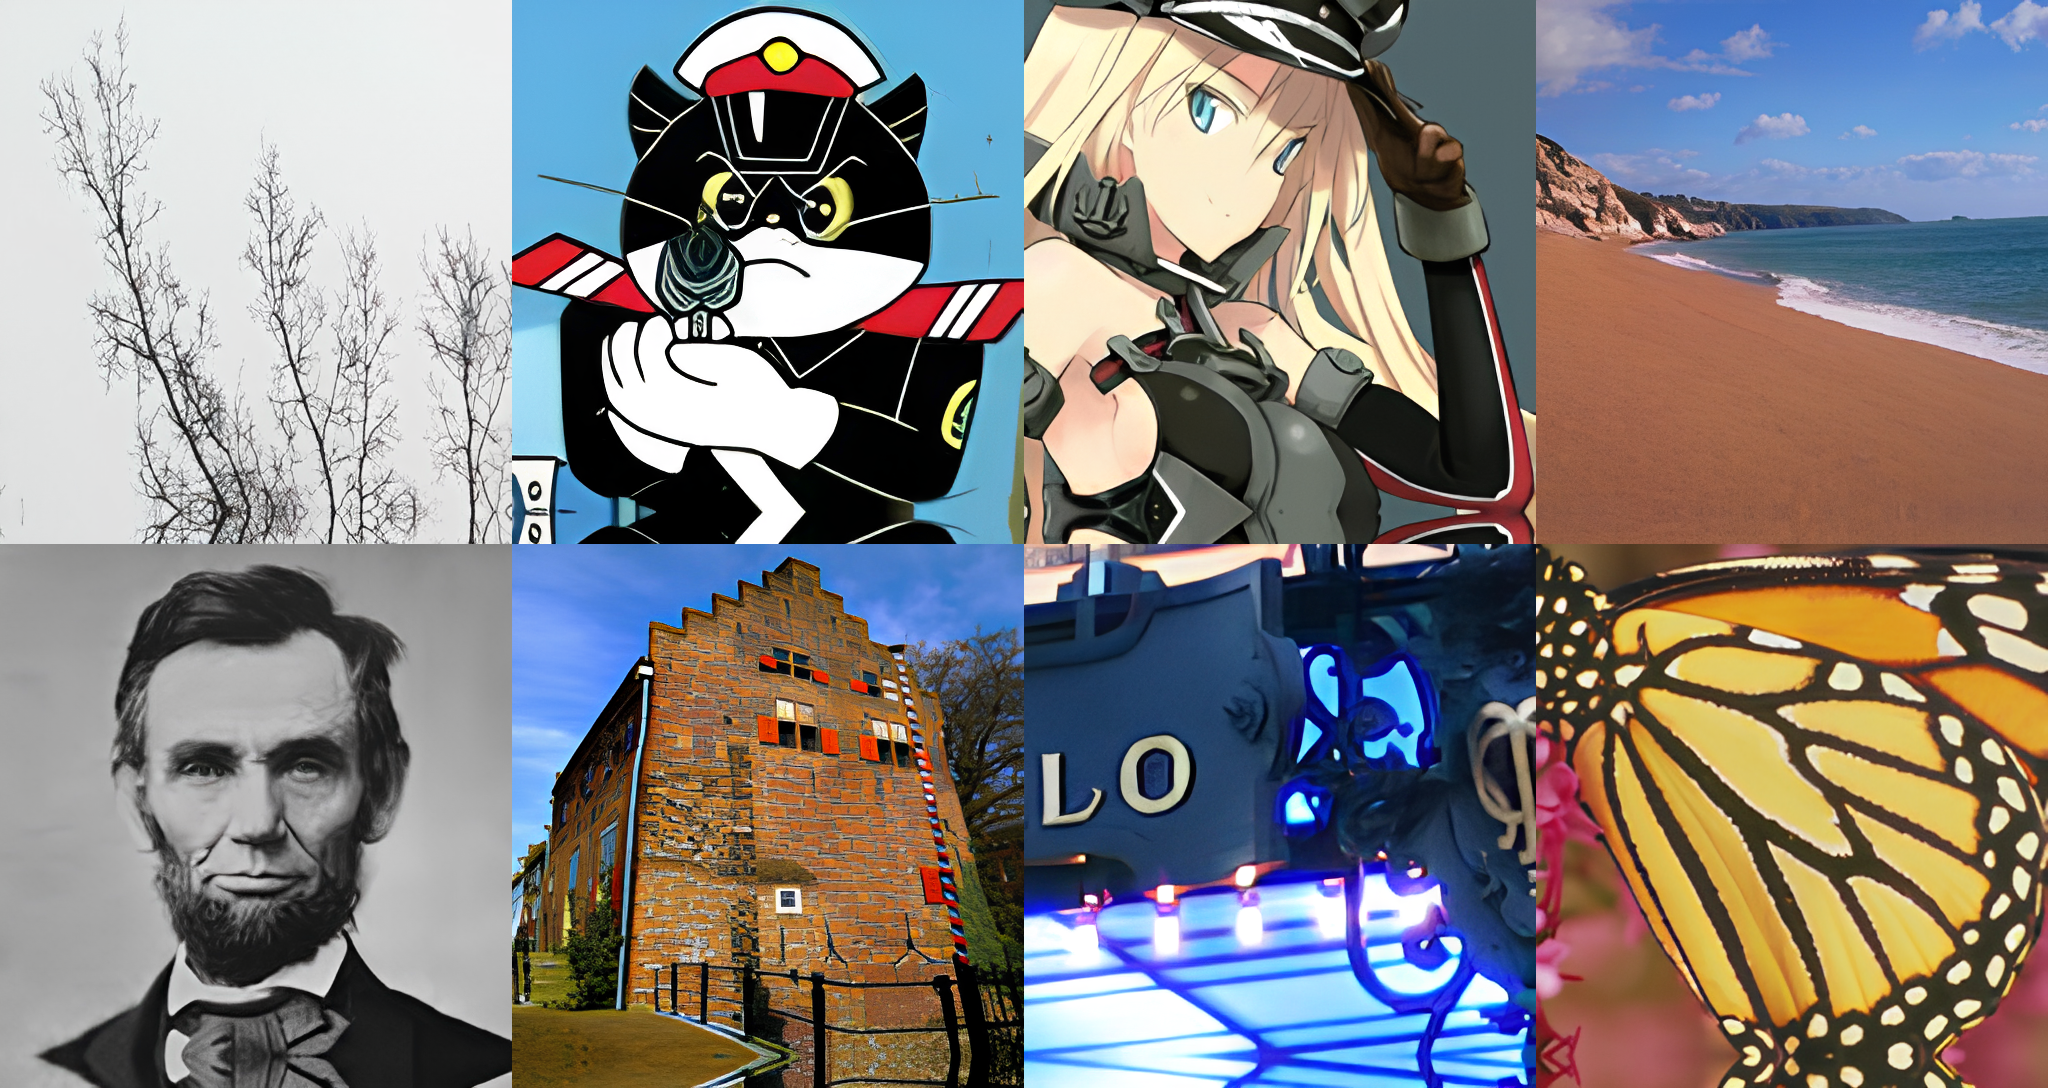

In [38]:
sr_images = numpy_to_pil(sr_images)
image_grid(sr_images, 2, 4)